### Курсовой проект для курса "Python для Data Science"

#### Автор:
Хусаинов Ильдар

#### Материалы к проекту (файлы):
* train.csv
* test.csv

#### Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

#### Целевая переменная:
Price

#### Основная метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

#### Вспомогательная метрика:
MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 100

warnings.filterwarnings('ignore') # игнорирование предупреждений
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Анализ датасета train.csv

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


1. Имеются пропущенные значения наблюдений в столбцах LifeSquare и Healthcare_1;
2. LifeSquare заполним средними значениями, а если LifeSquare превышает Square, то 85% от Square;
3. Healthcare_1 - заполним нулями;
4. Поля типа object необходимо преобразовать в числовой тип;

In [4]:
data.describe()

Id    DistrictId         Rooms        Square   LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  7887.000000   
mean    8383.40770     50.400800      1.890500     56.315775    37.199645   
std     4859.01902     43.587592      0.839512     21.058732    86.241209   
min        0.00000      0.000000      0.000000      1.136859     0.370619   
25%     4169.50000     20.000000      1.000000     41.774881    22.769832   
50%     8394.50000     36.000000      2.000000     52.513310    32.781260   
75%    12592.50000     75.000000      2.000000     65.900625    45.128803   
max    16798.00000    209.000000     19.000000    641.065193  7480.592129   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  1.000000e+04  10000.000000   
mean        6.273300      8.526700     12.609400  3.990166e+03      0.118858   
std        28.560917      5.241148      6.775974  2.005003e+05      0.119025   
min         0.000000      1.000000      0.000000  1.910000e+03      0.000000   
25%         1.000000      4.000000      9.000000  1.974000e+03      0.017647   
50%         6.000000      7.000000     13.000000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.000000  2.001000e+03      0.195781   
max      2014.000000     42.000000    117.000000  2.005201e+07      0.521867   

           Social_1      Social_2      Social_3  Healthcare_1   Helthcare_2  \
count  10000.000000  10000.000000  10000.000000   5202.000000  10000.000000   
mean      24.687000   5352.157400      8.039200   1142.904460      1.319500   
std       17.532614   4006.799803     23.831875   1021.517264      1.493601   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000    350.000000      0.000000   
50%       25.000000   5285.000000      2.000000    900.000000      1.000000   
75%       36.000000   7227.000000      5.000000   1548.000000      2.000000   
max       74.000000  19083.000000    141.000000   4849.000000      6.000000   

            Shops_1          Price  
count  10000.000000   10000.000000  
mean       4.231300  214138.857399  
std        4.806341   92872.293865  
min        0.000000   59174.778028  
25%        1.000000  153872.633942  
50%        3.000000  192269.644879  
75%        6.000000  249135.462171  
max       23.000000  633233.466570

1. Видны экстремумы по полям Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear

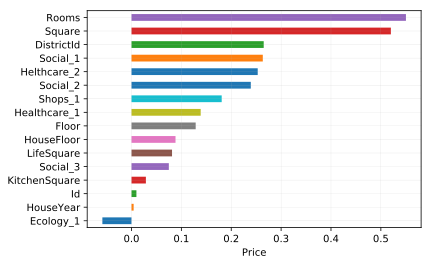

In [5]:
data.corr().drop('Price', axis=1).loc['Price'].sort_values().plot('barh')
plt.grid(linewidth=0.3, alpha=0.4)
plt.xlabel('Price');

1. Видно сильную корреляцию с ценой полей Rooms, Square, DistrictId, Social_1, Healthcare_2, Social_2
2. Поля Id и HouseYear практически не коррелируют с ценой, но это ещё не значит что признак не нужен
3. Проверим HouseYear

#### HouseYear

In [6]:
data['HouseYear'].unique()

array([    1969,     1978,     1968,     1977,     1976,     2011,
           1960,     2014,     1973,     1959,     1999,     1980,
           1979,     1983,     2001,     2012,     2002,     1996,
           1964,     2018,     1972,     1965,     1984,     1961,
           1971,     1963,     2017,     1970,     1981,     2003,
           2016,     1991,     1975,     2006,     2009,     1985,
           1974,     1994,     2000,     1987,     1998,     2005,
           1990,     1982,     1997,     2015,     2008,     2010,
           2004,     2007,     1967,     1957,     1962,     1993,
           1966,     1955,     1937,     1992,     1954,     1995,
           2019,     1948,     1986,     2013,     1989,     1958,
           1938,     1956,     1988,     2020,     1951,     1952,
           1935,     1914,     1932,     1950,     1917,     1918,
           1940, 20052011,     1942,     1939,     1934,     1931,
           1919,     1912,     1953,     1936,     1947,     1

In [7]:
data.loc[(data['HouseYear'] > 2020) | (data['HouseYear'] < 1910), :]

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
1497  10814         109    1.0  37.265070   20.239714            9.0      9   
4189  11607         147    2.0  44.791836   28.360393            5.0      4   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1497        12.0   20052011   0.136330         B         B        30   
4189         9.0       4968   0.319809         B         B        25   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
1497      6141        10         262.0            3        6       B   
4189      4756        16        2857.0            5        8       B   

              Price  
1497  254084.534396  
4189  243028.603096

Ошибки надо будет править функцией

#### Square

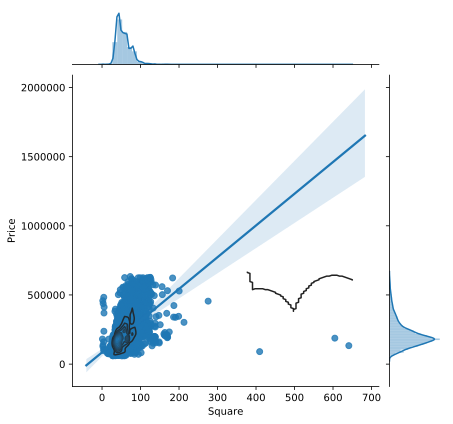

In [8]:
sns.jointplot(data['Square'], 
              data['Price'],
              kind='reg').plot_joint(sns.kdeplot, zorder=4, n_levels=10);

На графике выше хорошо видны выбросы при площадях больше 250 кв.м

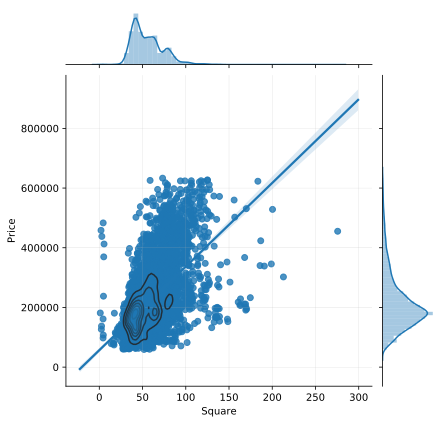

In [9]:
sns.jointplot((data.loc[data['Square'] < 300, 'Square']), 
              (data.loc[data['Square'] < 300, 'Price']),
              kind='reg').plot_joint(sns.kdeplot, zorder=4, n_levels=6);
plt.grid(linewidth=0.3, alpha=0.5);

In [10]:
data.loc[data['Square'] > 300, :]

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
4262     28           9    2.0  604.705972         NaN            1.0     17   
4690   2307         102    1.0  409.425181  410.639749           10.0      4   
6977  11602          30    2.0  641.065193  638.163193           10.0     20   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
4262        18.0       1977   0.161532         B         B        25   
4690         4.0       2016   0.238617         B         B        26   
6977        19.0       2019   0.000078         B         B        22   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
4262      5648         1          30.0            2        4       B   
4690      3889         6         705.0            3        6       B   
6977      6398       141        1046.0            3       23       B   

              Price  
4262  187717.242538  
4690   90470.430830  
6977  133529.681562

В целом таких значений мало, можно будет приравнять к среднему

#### Rooms

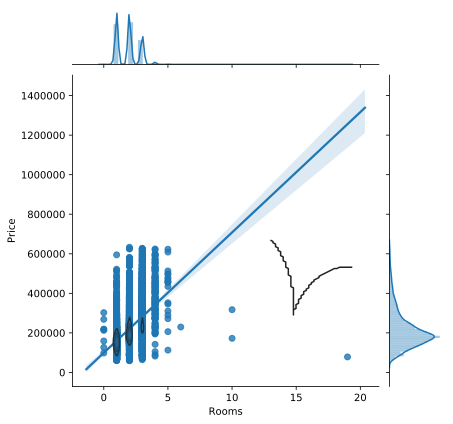

In [11]:
sns.jointplot(data['Rooms'], 
              data['Price'],
              kind='reg').plot_joint(sns.kdeplot, zorder=3, n_levels=4);

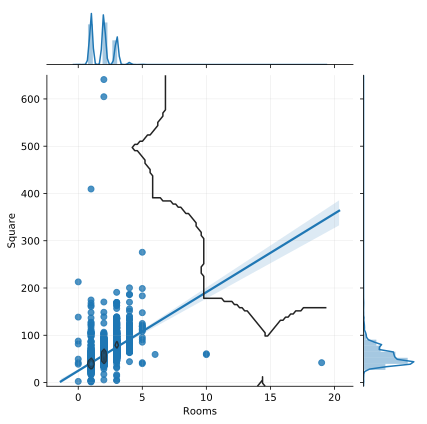

In [12]:
sns.jointplot(data['Rooms'], 
              data['Square'],
              kind='reg').plot_joint(sns.kdeplot, zorder=3, n_levels=4)
plt.grid(linewidth=0.3, alpha=0.5);

In [13]:
data.loc[(data['Rooms'] == 5) & (data['Square'] < 100), :]

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
1422  4282         195    5.0  95.617533   62.377052            7.0      7   
3271  6358          27    5.0  42.003293         NaN            0.0      5   
4431  7594          53    5.0  39.906082   39.394024            1.0      5   
8726   238          88    5.0  90.762276   70.991790            5.0      1   
8925  4214         105    5.0  85.313605   56.686693            5.0      4   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1422         7.0       1940   0.015017         B         B        17   
3271        12.0       1977   0.011654         B         B         4   
4431         1.0       1977   0.049637         B         B        34   
8726         9.0       1972   0.127376         B         B        43   
8925        12.0       1967   0.040243         B         B        25   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
1422      3079        59        2890.0            0        8       B   
3271       915         0           NaN            0        0       B   
4431      7759         0         229.0            1        3       B   
8726      8429         3           NaN            3        9       B   
8925      3478        11        2729.0            3        1       B   

              Price  
1422  479525.147323  
3271  112693.641769  
4431  206148.845716  
8726  289683.939174  
8925  461678.738428

1. Видно, что основная масса количества комнат сконцентрирована в диапазоне 1-4;
2. 5-комнатные тоже есть, но с квадратурой меньше 85 скорее всего ошибки;
3. Комнаты 1-5 оставим, всё остальное необходимо приравнять к среднему значению по площади квартиры.

### Создание функций для корректировки признаков, добавления полей

In [14]:
# Функция заполняющая экстремумы комнат комнатами средними по площади
def prepare_rooms(df, source_df):
    min_sq = 18
    max_sq = 125
    mean_sq = source_df.loc[(source_df['Rooms'] > 0) & 
                            (source_df['Rooms'] <= 5) & 
                            (source_df['Square'] > min_sq) & 
                            (source_df['Square'] < max_sq), :].groupby('Rooms')[['Square']].mean().values    
    # заполнение экстремумов
    # mean_sq[i][0] + (mean_sq[i + 1][0] - val[0]) / 2) --> среднее между средними размерами квартир
    for i, val in enumerate(mean_sq):
        if i < len(mean_sq) - 1:
            df.loc[(df['Rooms'] > 5) | (df['Rooms'] < 1) &
                   (df['Square'] <= mean_sq[i][0] + (mean_sq[i + 1][0] - val[0]) / 2), 'Rooms'] = i + 1
        else:
            df.loc[(df['Rooms'] > 5) | 
                   (df['Rooms'] < 1), 'Rooms'] = i + 1
    return df 

In [15]:
# mean square by rooms
def prepare_square(df, source_df):
    min_sq = 18
    max_sq = 125
    mean_sq = source_df.loc[(source_df['Rooms'] > 0) & 
                            (source_df['Rooms'] <= 5) & 
                            (source_df['Square'] > min_sq) & 
                            (source_df['Square'] < max_sq), :].groupby('Rooms',
                                        as_index=False)[['Square']].mean().rename(columns={'Square':'mean_square'})  
    
    df = pd.merge(df, mean_sq, on='Rooms', how='left')
    df.loc[(df['Square'] <= min_sq) | (df['Square'] >= max_sq), 'Square'] = df['mean_square'] 
    return df

In [16]:
# Функция вычисляющая среднее значение цены по району сгруппированное по признаку (любому)
def join_mean_sign(df, source_df, mode='train', sign='sign', sign_title='sign_title'):
    mean_dstr = source_df.groupby(['DistrictId', 
                            sign], as_index=False)[['Price']].mean().rename(columns={'Price':sign_title})    
    df = pd.merge(df, mean_dstr, on=['DistrictId', sign], how='left')
    if mode == 'test':
        df[sign_title] = df[sign_title].fillna(source_df[sign_title].mean())
    return df

In [17]:
# Функция заполняющая превышающую жилую площадь средними значениями и значением (Square - 15%)
def prepare_life(df, source_df):
    df['LifeSquare'] = df['LifeSquare'].fillna(source_df['LifeSquare'].mean())
    df.loc[df['LifeSquare'] > df['Square'], 'LifeSquare'] = df['Square'] * 0.85
    return df

In [18]:
# Функция заполняющая превышающую площадь средними значениями и значением (Square - 85%)
def prepare_kitchen(df):
    df.loc[df['KitchenSquare'] > df['Square'], 'KitchenSquare'] = df['Square'] * 0.15
    return df

In [19]:
def prepare_year(df):
    df.loc[(df['HouseYear'] > 2020) | (df['HouseYear'] < 1910), 'HouseYear'] = \
        round(df.loc[(df['HouseYear'] < 2020) & (df['HouseYear'] > 1910), 'HouseYear'].mean())
    return df

In [20]:
def get_integer(df):
    cat_feats=('Ecology_2', 'Ecology_3', 'Shops_2')
    for col in cat_feats:
        if df[col].dtype == 'object':
            df[col] = (df[col] == 'B').astype(int)
    return df

In [21]:
def fillna_healthcare_1(df):
    df['Healthcare_1'] = df['Healthcare_1'].fillna(0)
    return df

In [22]:
def add_flat_qty(df, source_df):
    distr_info = source_df['DistrictId'].value_counts(normalize=True).\
            reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'flat_qty_distr'})    
    df = pd.merge(df, distr_info, on='DistrictId', how='left')
    df['flat_qty_distr'] = df['flat_qty_distr'].fillna(0.000143)
    return df

In [23]:
def prepare_house_floor(df):
    df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor'] = df['Floor']
    df.loc[(df['HouseFloor'] > 45) & (df['HouseYear'] < 2000), 'HouseFloor'] = df['Floor']
    return df

In [24]:
def prepare_data(df, source_df, mode='train'):
    df = prepare_rooms(df, source_df)
    df = prepare_square(df, source_df)  
    df = get_integer(df)
    df = join_mean_sign(df, source_df, mode, sign='Rooms', sign_title='mean_price')
    df = join_mean_sign(df, source_df, mode, sign='Shops_1', sign_title='mean_price_sh1')
    df = join_mean_sign(df, source_df, mode, sign='Helthcare_2', sign_title='mean_price_hl2')
    df = prepare_life(df, source_df)
    df = prepare_kitchen(df)
    df = prepare_year(df)    
    df = fillna_healthcare_1(df)
    df = add_flat_qty(df, source_df) 
    df = prepare_house_floor(df)
    return df

### Разделение train на train & valid с пропорцией 70/30 для обучения модели
train_test_split 

In [25]:
train, valid = train_test_split(data, test_size=0.3, random_state=43)

In [26]:
train.shape, valid.shape

((7000, 20), (3000, 20))

### Подготовка данных

train:

In [27]:
train = prepare_data(train, train)

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 6999
Data columns (total 25 columns):
Id                7000 non-null int64
DistrictId        7000 non-null int64
Rooms             7000 non-null float64
Square            7000 non-null float64
LifeSquare        7000 non-null float64
KitchenSquare     7000 non-null float64
Floor             7000 non-null int64
HouseFloor        7000 non-null float64
HouseYear         7000 non-null int64
Ecology_1         7000 non-null float64
Ecology_2         7000 non-null int64
Ecology_3         7000 non-null int64
Social_1          7000 non-null int64
Social_2          7000 non-null int64
Social_3          7000 non-null int64
Healthcare_1      7000 non-null float64
Helthcare_2       7000 non-null int64
Shops_1           7000 non-null int64
Shops_2           7000 non-null int64
Price             7000 non-null float64
mean_square       7000 non-null float64
mean_price        7000 non-null float64
mean_price_sh1    7000 non-null float

In [29]:
train.describe()

Id   DistrictId        Rooms       Square   LifeSquare  \
count   7000.000000  7000.000000  7000.000000  7000.000000  7000.000000   
mean    8336.664429    50.785000     1.883143    55.606118    35.308326   
std     4881.431632    43.673161     0.811794    17.514507    14.040185   
min        0.000000     0.000000     1.000000    18.983962     0.370619   
25%     4093.500000    21.000000     1.000000    41.728633    25.180657   
50%     8311.500000    37.000000     2.000000    52.243896    36.213234   
75%    12561.500000    76.000000     2.000000    65.731864    40.165007   
max    16797.000000   209.000000     5.000000   124.914431   118.048978   

       KitchenSquare        Floor   HouseFloor    HouseYear    Ecology_1  \
count    7000.000000  7000.000000  7000.000000  7000.000000  7000.000000   
mean        5.875091     8.501857    13.350857  1984.843000     0.118175   
std         5.211587     5.231762     5.911602    18.473988     0.118478   
min         0.000000     1.000000     1.000000  1912.000000     0.000000   
25%         1.000000     4.000000     9.000000  1974.000000     0.017647   
50%         6.000000     7.000000    14.000000  1977.000000     0.075424   
75%         9.000000    12.000000    17.000000  2001.000000     0.195781   
max       123.000000    42.000000    48.000000  2020.000000     0.521867   

         Ecology_2    Ecology_3     Social_1      Social_2     Social_3  \
count  7000.000000  7000.000000  7000.000000   7000.000000  7000.000000   
mean      0.989857     0.971571    24.914714   5404.376143     8.334857   
std       0.100207     0.166206    17.567896   4023.608947    24.563011   
min       0.000000     0.000000     0.000000    168.000000     0.000000   
25%       1.000000     1.000000     6.000000   1564.000000     0.000000   
50%       1.000000     1.000000    25.000000   5285.000000     2.000000   
75%       1.000000     1.000000    36.000000   7425.000000     5.000000   
max       1.000000     1.000000    74.000000  19083.000000   141.000000   

       Healthcare_1  Helthcare_2      Shops_1      Shops_2          Price  \
count   7000.000000  7000.000000  7000.000000  7000.000000    7000.000000   
mean     601.600714     1.334429     4.279286     0.918286  213806.866170   
std      939.013250     1.498206     4.878507     0.273949   92904.679032   
min        0.000000     0.000000     0.000000     0.000000   59877.592523   
25%        0.000000     0.000000     1.000000     1.000000  153628.642039   
50%       30.000000     1.000000     3.000000     1.000000  192121.673389   
75%     1015.000000     2.000000     6.000000     1.000000  248675.926817   
max     4849.000000     6.000000    23.000000     1.000000  625678.644994   

       mean_square     mean_price  mean_price_sh1  mean_price_hl2  \
count  7000.000000    7000.000000     7000.000000     7000.000000   
mean     55.606118  213806.866170   213806.866170   213806.866170   
std      14.071999   75373.231850    59671.151771    58431.960544   
min      41.060619   82121.567655    73902.146850    87268.098968   
25%      41.060619  161959.712850   169012.281003   169012.281003   
50%      56.213980  201000.153796   205606.438517   204483.973645   
75%      56.213980  248220.157525   243205.851010   244842.573758   
max      98.748008  624156.003381   541173.319391   541173.319391   

       flat_qty_distr  
count     7000.000000  
mean         0.023670  
std          0.026005  
min          0.000143  
25%          0.005429  
50%          0.010429  
75%          0.051143  
max          0.082714

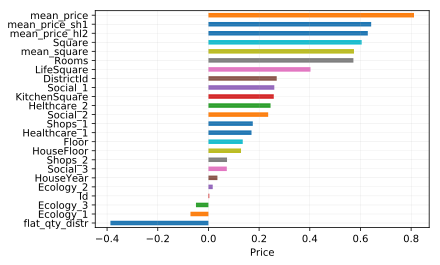

In [30]:
train.corr().drop('Price', axis=1).loc['Price'].sort_values().plot('barh')
plt.grid(linewidth=0.3, alpha=0.4)
plt.xlabel('Price');

valid:

In [31]:
valid = prepare_data(valid, train, mode='test')

In [32]:
valid.describe()

Id   DistrictId        Rooms       Square   LifeSquare  \
count   3000.000000  3000.000000  3000.000000  3000.000000  3000.000000   
mean    8492.475333    49.504333     1.901333    56.167268    35.279649   
std     4805.356833    43.381301     0.815569    17.509836    14.285165   
min       10.000000     0.000000     1.000000    18.509177     0.641822   
25%     4343.250000    17.000000     1.000000    41.842123    25.691122   
50%     8562.500000    34.000000     2.000000    53.140523    35.308326   
75%    12690.500000    74.000000     2.000000    66.251210    41.260840   
max    16798.000000   205.000000     5.000000   124.936036   115.110477   

       KitchenSquare        Floor   HouseFloor    HouseYear    Ecology_1  \
count    3000.000000  3000.000000  3000.000000  3000.000000  3000.000000   
mean        5.829904     8.584667    13.535000  1984.917667     0.120450   
std         4.725449     5.263402     5.816074    18.261582     0.120297   
min         0.000000     1.000000     1.000000  1910.000000     0.000000   
25%         1.000000     4.000000     9.000000  1974.000000     0.017647   
50%         6.000000     7.000000    14.000000  1977.000000     0.075779   
75%         9.000000    12.000000    17.000000  2001.000000     0.195781   
max        72.000000    32.000000    48.000000  2020.000000     0.521867   

         Ecology_2    Ecology_3     Social_1      Social_2     Social_3  \
count  3000.000000  3000.000000  3000.000000   3000.000000  3000.000000   
mean      0.991333     0.974667    24.155667   5230.313667     7.349333   
std       0.092706     0.157162    17.441373   3965.294320    22.020239   
min       0.000000     0.000000     0.000000    168.000000     0.000000   
25%       1.000000     1.000000     6.000000   1564.000000     0.000000   
50%       1.000000     1.000000    25.000000   5212.000000     2.000000   
75%       1.000000     1.000000    35.000000   7065.000000     4.000000   
max       1.000000     1.000000    74.000000  19083.000000   141.000000   

       Healthcare_1  Helthcare_2      Shops_1      Shops_2          Price  \
count   3000.000000  3000.000000  3000.000000  3000.000000    3000.000000   
mean     578.061333     1.284667     4.119333     0.915667  214913.503600   
std      915.753372     1.482463     4.632449     0.277933   92807.545445   
min        0.000000     0.000000     0.000000     0.000000   59174.778028   
25%        0.000000     0.000000     1.000000     1.000000  155038.574255   
50%       30.000000     1.000000     3.000000     1.000000  192476.219671   
75%      990.000000     2.000000     6.000000     1.000000  250129.811089   
max     4849.000000     6.000000    23.000000     1.000000  633233.466570   

       mean_square     mean_price  mean_price_sh1  mean_price_hl2  \
count  3000.000000    3000.000000     3000.000000     3000.000000   
mean     55.924559  210100.677930   211416.184631   211769.603553   
std      14.160308   69846.052411    57568.858132    57054.120711   
min      41.060619   82121.567655    73902.146850   126159.187880   
25%      41.060619  161959.712850   169012.281003   169012.281003   
50%      56.213980  201000.153796   200173.725849   202785.635434   
75%      56.213980  246561.426047   239844.678667   241968.144315   
max      98.748008  554965.509029   486057.129888   486057.129888   

       flat_qty_distr  
count     3000.000000  
mean         0.024525  
std          0.026719  
min          0.000143  
25%          0.005286  
50%          0.010571  
75%          0.051143  
max          0.082714

In [33]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 25 columns):
Id                3000 non-null int64
DistrictId        3000 non-null int64
Rooms             3000 non-null float64
Square            3000 non-null float64
LifeSquare        3000 non-null float64
KitchenSquare     3000 non-null float64
Floor             3000 non-null int64
HouseFloor        3000 non-null float64
HouseYear         3000 non-null int64
Ecology_1         3000 non-null float64
Ecology_2         3000 non-null int64
Ecology_3         3000 non-null int64
Social_1          3000 non-null int64
Social_2          3000 non-null int64
Social_3          3000 non-null int64
Healthcare_1      3000 non-null float64
Helthcare_2       3000 non-null int64
Shops_1           3000 non-null int64
Shops_2           3000 non-null int64
Price             3000 non-null float64
mean_square       3000 non-null float64
mean_price        3000 non-null float64
mean_price_sh1    3000 non-null float

### Обучение и выбор моделей обучения. LinearRegression or RandomForestRegression

In [34]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score, mean_squared_error as mse

In [36]:
# Обучение и выбор модели на жадном алгоритме
def model_create_greedy(train, valid, source_feats, model='lr'):   
    if model == 'lr':
        model = LR(n_jobs=-1)
    elif model == 'rf':
        model = RF(n_estimators=300, max_depth=12, min_samples_leaf=1, max_features=2, random_state=43, n_jobs=-1)
        
    feats_main = source_feats[:1]
    feats_added = source_feats[1:]
    r2_last = 0.0
    r2 = 0.1
    len_ft = len(feats_added)
    i = 1
     
    while i < len_ft:
        for feat in feats_added:                   
            source_feats = feats_main + [feat]
            model.fit(train.loc[:, source_feats], train['Price'])    
            pred_valid = model.predict(valid.loc[:, source_feats])
            r2 = r2_score(valid['Price'], pred_valid)
            if r2 > r2_last:
                features = source_feats
                ft = feat              
                r2_last = r2
        
        if ft in feats_added:
            feats_main = features
            feats_added.remove(ft)
        i += 1
    
    model.fit(train.loc[:, feats_main], train['Price'])
    pred_train = model.predict(train.loc[:, feats_main])
    pred_valid = model.predict(valid.loc[:, feats_main])
    r2 = r2_score(valid['Price'], pred_valid)
    print(f"Train: r2 = {r2_score(train['Price'], pred_train)}")
    print(f'Valid: r2 = {r2}')
          
    return model, feats_main

In [37]:
feats = ['Square', 'DistrictId', 'Rooms', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
         'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
         'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']
len(feats)

18

In [38]:
feats_mean = ['Square', 'Rooms', 'DistrictId', 'mean_price', 
              'mean_square', 'flat_qty_distr', 'mean_price_sh1', 'mean_price_hl2',
              'Social_1', 'Social_2', 'Social_3', 'LifeSquare', 'KitchenSquare',  
              'Floor', 'HouseFloor', 'HouseYear', 'Healthcare_1','Helthcare_2',             
              'Ecology_1', 'Ecology_2', 'Ecology_3', 'Shops_1', 'Shops_2']
              
len(feats_mean) 

23

LinearRegression:

In [39]:
%%time
model, feats_lr = model_create_greedy(train, valid, feats)

Train: r2 = 0.556504573301242
Valid: r2 = 0.5517731879090706
CPU times: user 2.09 s, sys: 18.3 ms, total: 2.11 s
Wall time: 542 ms


In [40]:
%%time
model, feats_lr = model_create_greedy(train, valid, feats_mean)

Train: r2 = 0.7187419616191804
Valid: r2 = 0.6576990950629957
CPU times: user 3.58 s, sys: 39.7 ms, total: 3.62 s
Wall time: 911 ms


RandomForestRegressor:

In [41]:
%%time
model2, feats_rf = model_create_greedy(train, valid, feats_mean, model='rf')

Train: r2 = 0.9124419052218394
Valid: r2 = 0.7241528869465113
CPU times: user 11min 46s, sys: 1min 7s, total: 12min 54s
Wall time: 3min 40s


In [42]:
%%time
model2, feats_rf = model_create_greedy(train, valid, feats, model='rf')

Train: r2 = 0.8909225070620654
Valid: r2 = 0.7271357466783406
CPU times: user 6min 37s, sys: 36.6 s, total: 7min 14s
Wall time: 6min 16s


In [43]:
feats_rf

['Square',
 'Social_2',
 'DistrictId',
 'Social_3',
 'HouseFloor',
 'Ecology_1',
 'HouseYear']

In [44]:
# Жадным алгоритмом выбраны следующие признаки
feats_rf_greedy = ['Square', 'Social_2', 'DistrictId', 'Social_3', 'HouseFloor', 'Ecology_1', 'HouseYear']
# feats_rf = feats_rf_greedy

Проверим RF на всех базовых признаках (без жадного алгоритма). Для этого сначала создадим функцию создания RF:

In [45]:
def create_RF(train, valid, feats, n_est=300, max_dp=11, max_ft=4, min_s_lf=2):
    model = RF(n_estimators=n_est, max_depth=max_dp, max_features=max_ft, min_samples_leaf=min_s_lf, 
               random_state=43, n_jobs=-1)
    model.fit(train.loc[:, feats], train['Price'])
    pred_train = model.predict(train.loc[:, feats])
    pred_valid = model.predict(valid.loc[:, feats])
    r2 = r2_score(valid['Price'], pred_valid)
    print(f"Train: r2 = {r2_score(train['Price'], pred_train)}")
    print(f'Valid: r2 = {r2}')
    
    return model

In [46]:
%%time
model = create_RF(train, valid, feats_rf, n_est=300, max_dp=11, max_ft=4, min_s_lf=2)

Train: r2 = 0.8572629211969043
Valid: r2 = 0.7213780571661299
CPU times: user 3.13 s, sys: 115 ms, total: 3.25 s
Wall time: 840 ms


__Вывод:__ 

Дополнительные признаки улучшают модель линейной регресси на 10%, но ухудшают RF на 0.3%. Несмотря на это, RF показывает результат на валидных данных на 7% лучше. Выбираем RF с признаками подобранными жадным алгоритмом.

Подберем параметры с помощью GridSearchCV:

In [47]:
parameters = [{'n_estimators': [30, 35, 40, 250, 300, 350], 
               'min_samples_leaf': np.arange(1, 3),
               'max_features': np.arange(1, 3),
               'max_depth': np.arange(10, 13)}]

In [48]:
%%time
forest = GridSearchCV(estimator=RF(random_state=43), 
                   param_grid=parameters,
                   scoring='r2',
                   cv=5,
                   n_jobs=-1)

CPU times: user 72 µs, sys: 1e+03 ns, total: 73 µs
Wall time: 78 µs


In [49]:
%%time
forest.fit(train.loc[:, feats_rf], train['Price'])

CPU times: user 3.09 s, sys: 401 ms, total: 3.49 s
Wall time: 47.3 s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=43, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [30, 35, 40, 250, 300, 350], 'min_samples_leaf': array([1, 2]), 'max_features': array([1, 2]), 'max_depth': array([10, 11, 12])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [50]:
forest.best_params_

{'max_depth': 12,
 'max_features': 2,
 'min_samples_leaf': 2,
 'n_estimators': 350}

In [51]:
pred_train = forest.predict(train.loc[:, feats_rf])
pred_valid = forest.predict(valid.loc[:, feats_rf])
r2 = r2_score(valid['Price'], pred_valid)
print(f"Train: r2 = {r2_score(train['Price'], pred_train)}")
print(f'Valid: r2 = {r2}')

Train: r2 = 0.8603437145790436
Valid: r2 = 0.7233142566792741


Пересоздадим модель учитываю наилучшие параметы:

In [64]:
model = create_RF(train, valid, feats_rf, n_est=350, max_dp=12, max_ft=2, min_s_lf=1)

Train: r2 = 0.890762430576633
Valid: r2 = 0.7268463068002242


### Датасет test.csv

In [53]:
test = pd.read_csv('test.csv')

In [54]:
test.shape

(5000, 19)

In [55]:
test = prepare_data(test, train, mode='test')

In [56]:
test.shape

(5000, 24)

In [57]:
test.describe()

Id   DistrictId       Rooms       Square   LifeSquare  \
count   5000.000000  5000.000000  5000.00000  5000.000000  5000.000000   
mean    8412.595400    51.279200     1.90640    56.052948    35.229473   
std     4832.674037    44.179466     0.80757    17.446655    14.013644   
min        1.000000     0.000000     1.00000    18.149267     0.333490   
25%     4221.750000    21.000000     1.00000    41.888568    25.754751   
50%     8320.500000    37.000000     2.00000    52.879195    35.308326   
75%    12598.250000    77.000000     2.00000    66.261541    40.765372   
max    16795.000000   212.000000     5.00000   124.285215   118.667210   

       KitchenSquare        Floor   HouseFloor    HouseYear    Ecology_1  \
count    5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean        5.815851     8.632000    13.378800  1984.422800     0.119874   
std         4.605072     5.483228     6.113525    18.510985     0.120070   
min         0.000000     1.000000     1.000000  1910.000000     0.000000   
25%         1.000000     4.000000     9.000000  1973.000000     0.019509   
50%         6.000000     7.000000    14.000000  1977.000000     0.072158   
75%         9.000000    12.000000    17.000000  2000.000000     0.195781   
max       112.000000    78.000000    78.000000  2020.000000     0.521867   

         Ecology_2    Ecology_3     Social_1      Social_2     Social_3  \
count  5000.000000  5000.000000  5000.000000   5000.000000  5000.000000   
mean      0.990400     0.970200    24.933800   5406.900000     8.262600   
std       0.097518     0.170052    17.532202   4026.614773    23.863762   
min       0.000000     0.000000     0.000000    168.000000     0.000000   
25%       1.000000     1.000000     6.000000   1564.000000     0.000000   
50%       1.000000     1.000000    25.000000   5285.000000     2.000000   
75%       1.000000     1.000000    36.000000   7287.000000     5.000000   
max       1.000000     1.000000    74.000000  19083.000000   141.000000   

       Healthcare_1  Helthcare_2      Shops_1      Shops_2  mean_square  \
count   5000.000000   5000.00000  5000.000000  5000.000000  5000.000000   
mean     601.536400      1.31940     4.242800     0.917600    55.975612   
std      948.929796      1.47994     4.777365     0.275001    14.036434   
min        0.000000      0.00000     0.000000     0.000000    41.060619   
25%        0.000000      0.00000     1.000000     1.000000    41.060619   
50%       30.000000      1.00000     3.000000     1.000000    56.213980   
75%      990.000000      2.00000     6.000000     1.000000    56.213980   
max     4849.000000      6.00000    23.000000     1.000000    98.748008   

          mean_price  mean_price_sh1  mean_price_hl2  flat_qty_distr  
count    5000.000000     5000.000000     5000.000000     5000.000000  
mean   212937.246125   213746.437101   214105.725185        0.023258  
std     71301.235576    58325.250780    56821.621263        0.025918  
min     82121.567655    73902.146850    87556.385617        0.000143  
25%    162838.242071   170961.772816   170870.323963        0.005286  
50%    201000.153796   205606.438517   204523.579151        0.010000  
75%    246561.426047   243205.851010   245090.811779        0.051143  
max    570525.064275   541173.319391   541173.319391        0.082714

In [58]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 24 columns):
Id                5000 non-null int64
DistrictId        5000 non-null int64
Rooms             5000 non-null float64
Square            5000 non-null float64
LifeSquare        5000 non-null float64
KitchenSquare     5000 non-null float64
Floor             5000 non-null int64
HouseFloor        5000 non-null float64
HouseYear         5000 non-null int64
Ecology_1         5000 non-null float64
Ecology_2         5000 non-null int64
Ecology_3         5000 non-null int64
Social_1          5000 non-null int64
Social_2          5000 non-null int64
Social_3          5000 non-null int64
Healthcare_1      5000 non-null float64
Helthcare_2       5000 non-null int64
Shops_1           5000 non-null int64
Shops_2           5000 non-null int64
mean_square       5000 non-null float64
mean_price        5000 non-null float64
mean_price_sh1    5000 non-null float64
mean_price_hl2    5000 non-null float

#### Predict

In [59]:
test['Price'] = model.predict(test.loc[:, feats_rf])

In [60]:
test['Price'].describe()

count      5000.000000
mean     215107.450066
std       74482.747996
min       70159.489717
25%      168464.774672
50%      196831.775570
75%      248086.058176
max      511639.086607
Name: Price, dtype: float64

In [61]:
test.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0    725          58    2.0  49.882643   33.432782            6.0      6   
1  15856          74    2.0  69.263183   35.308326            1.0      6   
2   5480         190    1.0  41.060619   15.948246           12.0      2   
3  15664          47    2.0  73.046609   51.940842            9.0     22   
4  14275          27    1.0  47.527111   43.387569            1.0     17   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
0        14.0       1972   0.310199          1          1        11      2748   
1         6.0       1977   0.075779          1          1         6      1437   
2         5.0       1984   0.000000          1          1        30      7538   
3        22.0       2007   0.101872          1          1        23      4583   
4        17.0       2017   0.072158          1          1         2       629   

   Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2  mean_square  \
0         1           0.0            0        0        1    56.213980   
1         3           0.0            0        2        1    56.213980   
2        87        4702.0            5        5        1    41.060619   
3         3           0.0            3        3        1    56.213980   
4         1           0.0            0        0        0    41.060619   

      mean_price  mean_price_sh1  mean_price_hl2  flat_qty_distr  \
0  172422.686772   154561.861759   161184.158830        0.016143   
1  241612.319214   205606.438517   203213.646402        0.011286   
2  213806.866170   447869.821601   447869.821601        0.000714   
3  207059.384106   225877.135321   243435.200868        0.008714   
4  122004.158120   157998.659102   149742.578414        0.082714   

           Price  
0  175975.910751  
1  211210.340553  
2  291273.340938  
3  342632.470402  
4  139941.076934

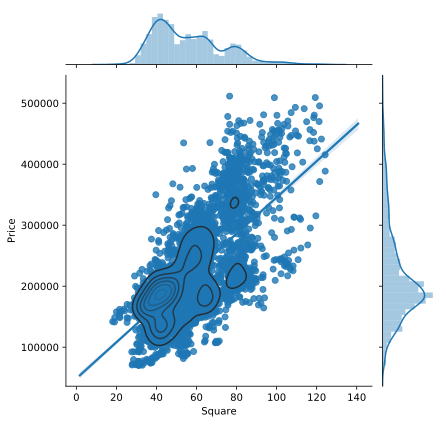

In [62]:
sns.jointplot(test['Square'], 
              test['Price'],
              kind='reg').plot_joint(sns.kdeplot, zorder=4, n_levels=6);

In [65]:
test.loc[:, ['Id', 'Price']].to_csv('IKhusainov_predictions.csv', index=None)